In [3]:
%%bash
cd /home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [4]:
%%bash 
cd /home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/models/research/
pip install .

Processing /home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1082203 sha256=6691b5a2fdba3a1f5efe46a4cb58823d9834c268f66401a4ceb61c27e6a97763
  Stored in directory: /tmp/pip-ephem-wheel-cache-ezz1s8ai/wheels/6d/04/9d/344d4299ff6b9f59435c27f0195ea89b070e63056c768715f4
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


You should consider upgrading via the '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/venv/bin/python3.7 -m pip install --upgrade pip' command.


In [43]:
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [44]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [45]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

#PATH
TF = '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/'

In [46]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"
    print(model_dir)
    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model


In [47]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = TF+'models/research/object_detection/data/clickable_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [48]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path(TF+'models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/models/research/object_detection/test_images/image1.jpg'),
 PosixPath('/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/07-tensorflow/models/research/object_detection/test_images/image2.jpg')]

In [49]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

/home/kimsoohyun/.keras/datasets/ssd_mobilenet_v1_coco_2017_11_17/saved_model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [34]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [36]:
detection_model.output_dtypes

{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [37]:
detection_model.output_shapes

{'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_scores': TensorShape([None, 100])}

In [39]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                   for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    return output_dict

In [41]:
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)

    display(Image.fromarray(image_np))

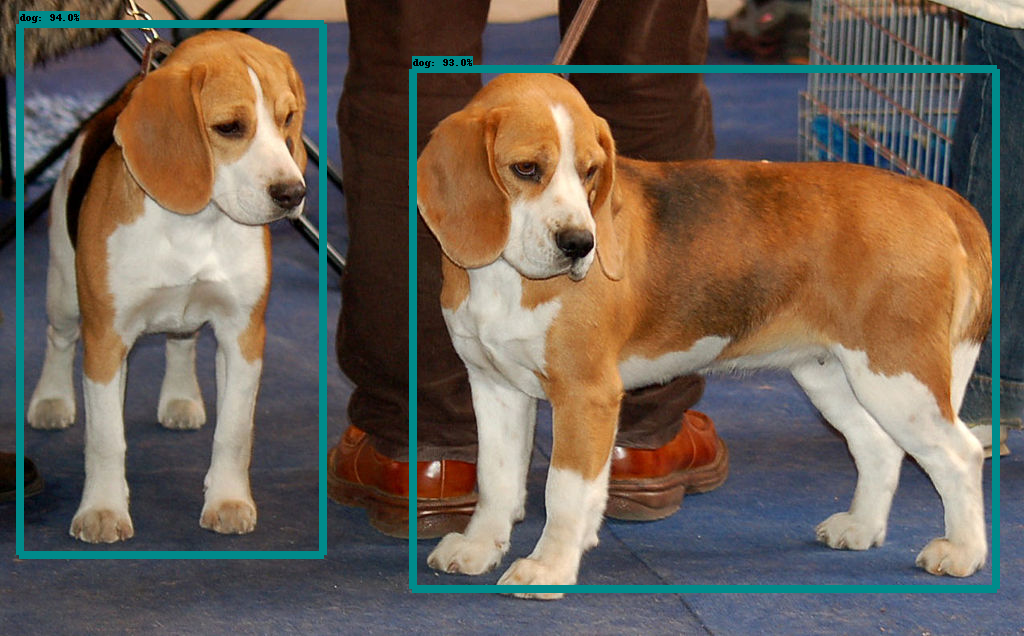

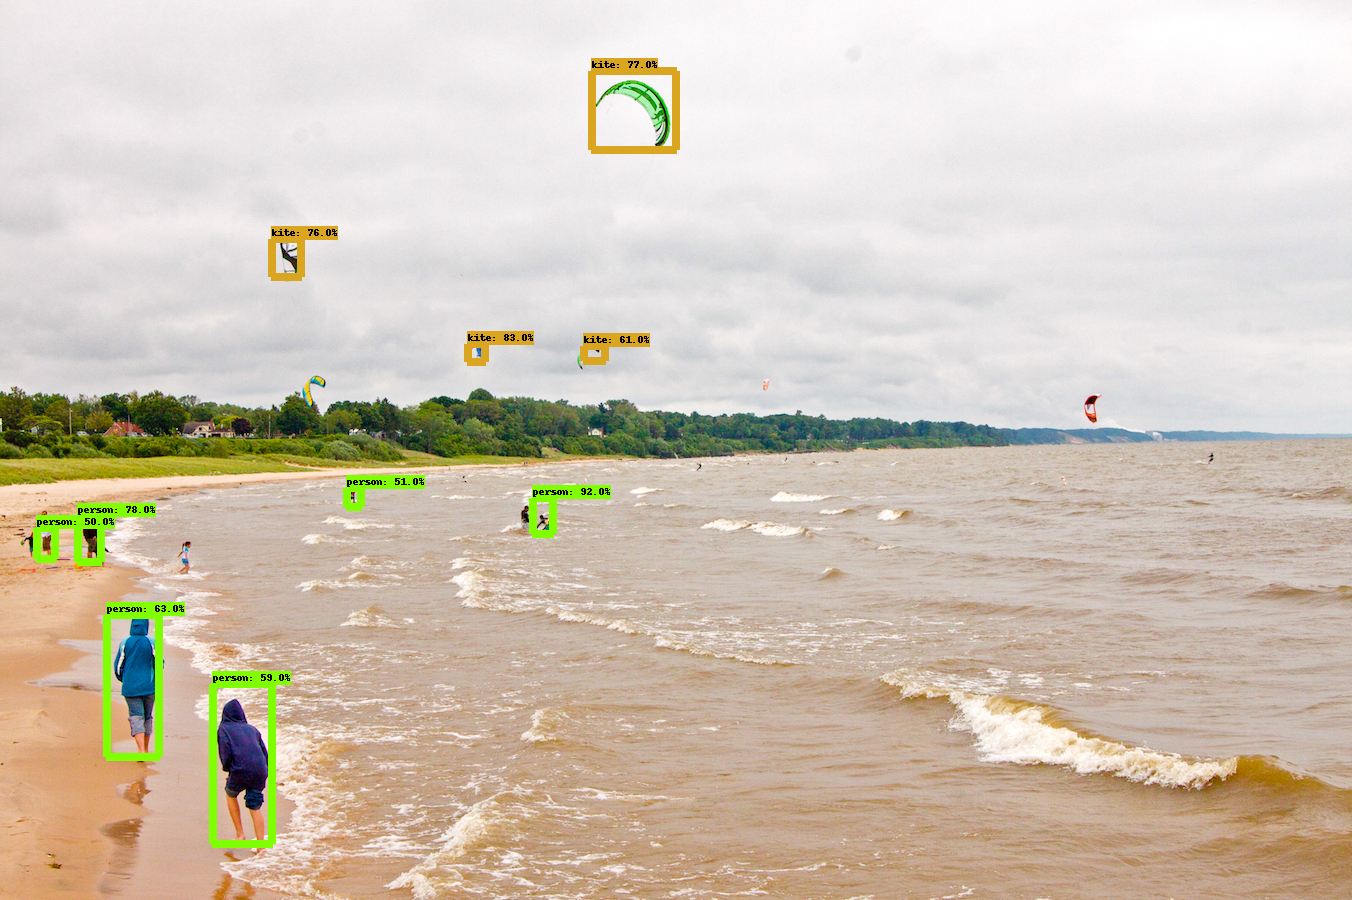

In [42]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(detection_model, image_path)